In [1]:
# Parameter inputs
aragorn_submit_url = "https://aragorn-u24.apps.renci.org/robokop/query"
trapi_submit_url = "http://automat-u24.apps.renci.org/robokopkg/1.3/query"

automat_cypher_submit_url = "https://automat-u24.apps.renci.org/robokopkg/cypher"
robokopkg_bolt_url = "bolt://robokopkg.renci.org:7687"

input_search_string = 'ppara'
output_search_string = 'liver fibrosis'

In [2]:
import requests
import os
import json
import time
import pandas as pd
import pprint
pp = pprint.PrettyPrinter(indent=5)

from datetime import datetime
from pathlib import Path
from collections import Counter

In [3]:
# Initializing directory to write
now = datetime.now()
dt_string = now.strftime("%Y-%m-%d_%H%M%S")
write_dir_trapi_automat = Path("output/compare/"+str(dt_string)+"/trapi/automat")
write_dir_trapi_automat.mkdir(parents=True, exist_ok=True)

write_dir_trapi_ara = Path("output/compare/"+str(dt_string)+"/trapi/ara")
write_dir_trapi_ara.mkdir(parents=True, exist_ok=True)

write_dir_cypher_automat = Path("output/compare/"+str(dt_string)+"/cypher/automat")
write_dir_cypher_automat.mkdir(parents=True, exist_ok=True)

write_dir_cypher_robokopkg = Path("output/compare/"+str(dt_string)+"/cypher/robokopkg")
write_dir_cypher_robokopkg.mkdir(parents=True, exist_ok=True)

In [4]:
# Pathway results to load
write_dir_cypher_automat = "output/compare/"+str(dt_string)+"/cypher/automat"
write_dir_cypher_robokopkg = "output/compare/"+str(dt_string)+"/cypher/robokopkg"
ARA_results_file = "output/compare/"+str(dt_string)+"/trapi/ara/results_ARA.csv"
TRAPI_results_file = "output/compare/"+str(dt_string)+"/trapi/automat/results_TRAPI.csv"
Cypher_ROBOKOPKG_results_file = "output/compare/"+str(dt_string)+"/cypher/robokopkg/results.csv"
Cypher_ROBOKOPKG_single_results_file = "output/compare/"+str(dt_string)+"/cypher/robokopkg_single/results.csv"
Cypher_Automat_results_file = "output/compare/"+str(dt_string)+"/cypher/automat/results.csv"
write_dir_compare = "output/compare/"+str(dt_string)+""
exemplar_results_file = "output/compare/"+str(dt_string)+"/exemplar_data.csv"
qbuilder_bio_entity_results_file = "output/compare/"+str(dt_string)+"/qbuilder_bio_entity_data.csv"
qbuilder_blank_results_file = "output/compare/"+str(dt_string)+"/qbuilder_blank_data.csv"
ARA_PPARA_Fibrosis_results_file = "output/compare/"+str(dt_string)+"/results_ARA_PPARA_Fibrosis.csv"

In [ ]:
results_date = "2023-07-07_153233" # report out 2023-07-10, 2023-07-24
results_date = "2023-08-03_112930" # report out 2023-08-07
results_date = "2023-08-18_125007" # report out 2023-08-21 (with additional IDs)
results_date = "2023-08-18_133624" # report out 2023-08-21 (without additional IDs)

In [ ]:
# Pathway results to load and write directory to specify (on David's work computer from previous run)
write_dir_cypher_automat = "output/compare/"+results_date+"/cypher/automat"
write_dir_cypher_robokopkg = "output/compare/"+results_date+"/cypher/robokopkg"
ARA_results_file = "output/compare/"+results_date+"/trapi/ara/results_ARA.csv"
TRAPI_results_file = "output/compare/"+results_date+"/trapi/automat/results_TRAPI.csv"
Cypher_ROBOKOPKG_results_file = "output/compare/"+results_date+"/cypher/robokopkg/results.csv"
Cypher_ROBOKOPKG_single_results_file = "output/compare/"+results_date+"/cypher/robokopkg_single/results.csv"
Cypher_Automat_results_file = "output/compare/"+results_date+"/cypher/automat/results.csv"
write_dir_compare = "output/compare/"+results_date+""
exemplar_results_file = "output/compare/"+results_date+"/exemplar_data.csv"
qbuilder_bio_entity_results_file = "output/compare/"+results_date+"/qbuilder_bio_entity_data.csv"
qbuilder_blank_results_file = "output/compare/"+results_date+"/qbuilder_blank_data.csv"
ARA_PPARA_Fibrosis_results_file = "output/compare/"+results_date+"/results_ARA_PPARA_Fibrosis.csv"

In [5]:
# Initializing Neo4j connection class
user = 'neo4j'
pw = ''

from neo4j import GraphDatabase
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session()
            response = list(session.run(query))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

## Generating data for comparison

### Getting "Input/Output" CURIES

In [6]:
results = requests.post(f'https://name-resolution-sri.renci.org/lookup?string={input_search_string}&offset=0&limit=100')
results_json = results.json()
#print(json.dumps(results_json,indent=4))
input_node_id_list = list(results_json.keys())
print(input_node_id_list)
print(f"Number of 'input' IDs: {len(input_node_id_list)}")

['UniProtKB:P37230', 'UniProtKB:Q07869', 'UniProtKB:Q95N78', 'PR:000013056', 'UniProtKB:P23204', 'NCBIGene:19013', 'NCBIGene:25747', 'NCBIGene:5465', 'NCBIGene:557714', 'NCBIGene:30755', 'NCBIGene:563298', 'UMLS:C0166415', 'NCBIGene:10891', 'NCBIGene:133522', 'UMLS:C2984537', 'NCBIGene:400931', 'PR:000040325', 'UMLS:C1868415', 'MESH:C000630914', 'MESH:C000634429', 'UMLS:C5226508', 'UMLS:C5197094', 'UMLS:C5417797', 'REACT:R-SSC-400204', 'REACT:R-BTA-400204', 'UMLS:C1518805', 'REACT:R-DRE-400204', 'REACT:R-HSA-400204', 'REACT:R-MMU-400204', 'REACT:R-BTA-9734475', 'REACT:R-SSC-9734475', 'REACT:R-HSA-879724', 'REACT:R-DRE-9734475', 'REACT:R-HSA-9734475', 'REACT:R-CFA-400204', 'REACT:R-MMU-9734475', 'REACT:R-RNO-400204', 'REACT:R-XTR-400204', 'REACT:R-CFA-9734475', 'REACT:R-RNO-9734475', 'REACT:R-XTR-9734475', 'REACT:R-DME-400204', 'REACT:R-HSA-1989781', 'REACT:R-BTA-4341070', 'REACT:R-DME-9734475', 'REACT:R-BTA-400143', 'REACT:R-DRE-400143', 'REACT:R-DRE-4341070', 'REACT:R-MMU-400143', 'RE

In [ ]:
# TO-DO- sanity check and get the preferred labels for each of these - output as table
for id, name_list in results_json.items():
    print(f"{id}: {name_list}")

In [7]:
results = requests.post(f'https://name-resolution-sri.renci.org/lookup?string={output_search_string}&offset=0&limit=100')
results_json = results.json()
#print(json.dumps(results_json,indent=4))
output_node_id_list = list(results_json.keys())
print(output_node_id_list)
print(f"Number of 'output' IDs: {len(output_node_id_list)}")

['HP:0001395', 'UMLS:C4227681', 'UMLS:C4034373', 'UMLS:C5189427', 'UMLS:C0544816', 'MONDO:0100430', 'MONDO:0018840', 'UMLS:C1397317', 'UMLS:C4068302', 'UMLS:C4481250', 'UMLS:C2827436', 'UMLS:C4321337', 'UMLS:C4695229', 'UMLS:C0494791', 'UMLS:C0400961', 'UMLS:C3864238', 'UMLS:C1960658', 'UMLS:C4695228', 'UMLS:C5563662', 'UMLS:C1407032', 'UMLS:C0400925', 'UMLS:C4749320', 'UMLS:C5548949', 'UMLS:C4533463', 'UMLS:C5689517', 'UMLS:C5689516', 'UMLS:C4722044', 'UMLS:C1856310', 'UMLS:C5439238', 'UMLS:C4722043', 'UMLS:C5548946', 'UMLS:C4533767', 'UMLS:C3277942', 'UMLS:C1385044', 'UMLS:C4070891', 'UMLS:C3873179', 'UMLS:C4070890', 'UMLS:C1954436', 'UMLS:C4070622', 'UMLS:C4036765', 'UMLS:C5215514', 'UMLS:C0451713', 'UMLS:C5686432', 'UMLS:C3275636', 'UMLS:C4750548', 'UMLS:C5549445', 'UMLS:C5549441', 'UMLS:C2184113', 'UMLS:C5190480', 'UMLS:C5171263', 'UMLS:C5171261', 'UMLS:C5171262', 'UMLS:C2751577', 'UMLS:C1869017', 'UMLS:C4030819', 'UMLS:C2749679', 'UMLS:C5697513', 'UMLS:C4732266', 'UMLS:C3869480',

In [ ]:
# TO-DO- sanity check and get the preferred labels for each of these - output as table
for id, name_list in results_json.items():
    print(f"{id}: {name_list[0]}")

In [ ]:
# List of input/output IDs in case the name resolver isn't working
input_node_id_list = ['NCBIGene:5465', 'MESH:C000630914', 'MESH:C000634429', 'NCBIGene:10891', 'NCBIGene:133522', 'NCBIGene:19013',
                      'NCBIGene:25747', 'NCBIGene:30755', 'NCBIGene:400931', 'NCBIGene:557714', 'NCBIGene:563298', 'NCBIGene:80205',
                      'PR:000013056', 'PR:000040325', 'REACT:R-BTA-400143', 'REACT:R-BTA-400183', 'REACT:R-BTA-400204',
                      'REACT:R-BTA-400206', 'REACT:R-BTA-4341070', 'REACT:R-BTA-9734475', 'REACT:R-CEL-4341070', 'REACT:R-CFA-400143',
                      'REACT:R-CFA-400183', 'REACT:R-CFA-400204', 'REACT:R-CFA-400206', 'REACT:R-CFA-9734475', 'REACT:R-DME-400143',
                      'REACT:R-DME-400183', 'REACT:R-DME-400204', 'REACT:R-DME-400206', 'REACT:R-DME-9734475', 'REACT:R-DRE-400143',
                      'REACT:R-DRE-400183', 'REACT:R-DRE-400204', 'REACT:R-DRE-400206', 'REACT:R-DRE-4341070', 'REACT:R-DRE-9734475',
                      'REACT:R-GGA-400143', 'REACT:R-GGA-4341070', 'REACT:R-HSA-1989781', 'REACT:R-HSA-400143', 'REACT:R-HSA-400183',
                      'REACT:R-HSA-400204', 'REACT:R-HSA-400206', 'REACT:R-HSA-4341070', 'REACT:R-HSA-5663156', 'REACT:R-HSA-879724',
                      'REACT:R-HSA-9734475', 'REACT:R-MMU-400143', 'REACT:R-MMU-400183', 'REACT:R-MMU-400204', 'REACT:R-MMU-400206',
                      'REACT:R-MMU-4341070', 'REACT:R-MMU-9734475', 'REACT:R-RNO-400143', 'REACT:R-RNO-400183', 'REACT:R-RNO-400204',
                      'REACT:R-RNO-400206', 'REACT:R-RNO-4341070', 'REACT:R-RNO-9734475', 'REACT:R-SSC-400183', 'REACT:R-SSC-400204',
                      'REACT:R-SSC-400206', 'REACT:R-SSC-9734475', 'REACT:R-XTR-400204', 'REACT:R-XTR-400206', 'REACT:R-XTR-4341070',
                      'REACT:R-XTR-9734475', 'UMLS:C0166415', 'UMLS:C1518805', 'UMLS:C1868415', 'UMLS:C2984537', 'UMLS:C5197094', 'UMLS:C5226508',
                      'UMLS:C5417797', 'UMLS:C5575466', 'UniProtKB:P23204', 'UniProtKB:P37230', 'UniProtKB:Q07869', 'UniProtKB:Q95N78']
output_node_id_list = ['HP:0001395', 'UMLS:C4227681', 'UMLS:C4034373', 'UMLS:C5189427', 'UMLS:C0544816', 'MONDO:0100430', 'MONDO:0018840',
                       'UMLS:C1397317', 'UMLS:C4068302', 'UMLS:C4481250', 'UMLS:C2827436', 'UMLS:C4321337', 'UMLS:C4695229', 'UMLS:C0494791',
                       'UMLS:C0400961', 'UMLS:C3864238', 'UMLS:C1960658', 'UMLS:C4695228', 'UMLS:C5563662', 'UMLS:C1407032', 'UMLS:C0400925',
                       'UMLS:C4749320', 'UMLS:C5548949', 'UMLS:C4533463', 'UMLS:C5689517', 'UMLS:C5689516', 'UMLS:C4722044', 'UMLS:C1856310',
                       'UMLS:C5439238', 'UMLS:C4722043', 'UMLS:C5548946', 'UMLS:C4533767', 'UMLS:C3277942', 'UMLS:C1385044', 'UMLS:C4070891',
                       'UMLS:C3873179', 'UMLS:C4070890', 'UMLS:C1954436', 'UMLS:C4070622', 'UMLS:C4036765', 'UMLS:C5215514', 'UMLS:C0451713',
                       'UMLS:C5686432', 'UMLS:C3275636', 'UMLS:C4750548', 'UMLS:C5549445', 'UMLS:C5549441', 'UMLS:C2184113', 'UMLS:C5190480',
                       'UMLS:C5171263', 'UMLS:C5171261', 'UMLS:C5171262', 'UMLS:C2751577', 'UMLS:C1869017', 'UMLS:C4030819', 'UMLS:C2749679',
                       'UMLS:C5697513', 'UMLS:C4732266', 'UMLS:C3869480', 'UMLS:C3869479', 'UMLS:C5413287', 'UMLS:C5416725', 'UMLS:C5414544', 'UMLS:C5414546']

### TRAPI methods

In [8]:
# Initializing TRAPI query and extracting results for ARA and Automat
query={
    "message": {
      "query_graph": {
        "edges": {
          "e00": {
            "subject": "n00",
              "object": "n01",
          "predicates":["biolink:related_to"]
          },
          "e01": {
            "subject": "n01",
              "object": "n02",
          "predicates":["biolink:related_to"]
          }
        },
        "nodes": {
          "n00": {
            "ids": input_node_id_list, #['NCBIGene:5465'], #
            "categories": ["biolink:GeneOrGeneProduct"]
          },
          "n01": {
              "categories": ["biolink:BiologicalEntity"]
          },
          "n02": {
            "ids": output_node_id_list, #["HP:0001395"],
            "categories": ["biolink:DiseaseOrPhenotypicFeature"]
          }
        }
      }
    }
  }


In [9]:
response_trapi = requests.post(trapi_submit_url,json=query)
print(response_trapi.status_code)
number_pathway_results_trapi = len(response_trapi.json()['message']['results'])
print(len(response_trapi.json()['message']['results']))

200
201


In [10]:
kg_trapi = response_trapi.json()['message']['knowledge_graph']
results_trapi = response_trapi.json()['message']['results']

In [11]:
import pandas as pd
import os

cols = []
for node in sorted(results_trapi[0]['node_bindings'].keys()):
    cols.append(node)
    cols.append(node + '_name')
results_trapi_df = pd.DataFrame(columns = cols)

results_trapi_list = []
for result in results_trapi:
    result_dict = {}
    for node in sorted(result['node_bindings'].keys()):
        node_id = result['node_bindings'][node][0]['id']
        result_dict[node] = node_id
        result_dict[node + '_name'] = kg_trapi['nodes'][node_id]['name']

    results_trapi_list.append(pd.DataFrame([result_dict]))
results_trapi_df = pd.concat(results_trapi_list)
display(results_trapi_df)
# results_trapi_df.to_csv(os.path.join(write_dir_trapi_automat,'results_TRAPI.csv'), index=False)
results_trapi_df.to_csv(TRAPI_results_file, index=False)

combined_node_list = ["_".join([row[1].replace(" ", "_"), row[3].replace(" ", "_"), row[5].replace(" ", "_")]) for row in results_trapi_df[cols].to_numpy()]
pp.pprint(combined_node_list)

,n00,n00_name,n01,n01_name,n02,n02_name
0,NCBIGene:5465,PPARA,NCBIGene:9104,RGN,HP:0001395,Hepatic fibrosis
0,UniProtKB:Q07869-1,peroxisome proliferator-activated receptor alp...,NCBIGene:183,AGT,HP:0001395,Hepatic fibrosis
0,NCBIGene:5465,PPARA,MONDO:0005154,liver disorder,MONDO:0100430,fibrotic liver disease
0,NCBIGene:10891,PPARGC1A,NCBIGene:183,AGT,HP:0001395,Hepatic fibrosis
0,NCBIGene:5465,PPARA,MONDO:0005154,liver disorder,HP:0012852,Hepatic bridging fibrosis
...,...,...,...,...,...,...
0,NCBIGene:133522,PPARGC1B,NCBIGene:7422,VEGFA,HP:0001395,Hepatic fibrosis
0,UniProtKB:Q07869-1,peroxisome proliferator-activated receptor alp...,NCBIGene:2147,F2,HP:0001395,Hepatic fibrosis
0,NCBIGene:5465,PPARA,NCBIGene:7057,THBS1,MONDO:0018840,isolated congenital hepatic fibrosis
0,NCBIGene:5465,PPARA,NCBIGene:4313,MMP2,HP:0001395,Hepatic fibrosis


[    'PPARA_RGN_Hepatic_fibrosis',
     'peroxisome_proliferator-activated_receptor_alpha_isoform_1_(human)_AGT_Hepatic_fibrosis',
     'PPARA_liver_disorder_fibrotic_liver_disease',
     'PPARGC1A_AGT_Hepatic_fibrosis',
     'PPARA_liver_disorder_Hepatic_bridging_fibrosis',
     'peroxisome_proliferator-activated_receptor_gamma_coactivator_1-alpha_isoform_h1_(human)_AGT_Hepatic_fibrosis',
     'PPARGC1A_SPP1_Hepatic_fibrosis',
     'PPARA_PKHD1_isolated_congenital_hepatic_fibrosis',
     'PPARA_COL1A1_Hepatic_fibrosis',
     'PPARGC1B_CCL2_Hepatic_fibrosis',
     'PPARA_LGALS1_Hepatic_fibrosis',
     'PPARGC1B_IL6_Hepatic_fibrosis',
     'PPARA_SPP1_Hepatic_fibrosis',
     'peroxisome_proliferator-activated_receptor_alpha_isoform_1_(human)_IGFBP1_Hepatic_fibrosis',
     'PPARA_F2_Hepatic_fibrosis',
     'PPARGC1B_AGT_isolated_congenital_hepatic_fibrosis',
     'PPARA_VIM_Hepatic_fibrosis',
     'PPARA_liver_disorder_isolated_congenital_hepatic_fibrosis',
     'PPARA_HGF_Hepatic_fibros

In [12]:
from collections import Counter
import json
import pprint
pp = pprint.PrettyPrinter(indent=5)

for i in range(number_pathway_results_trapi):
    # print(f"Pathway result: {combined_node_list[i]}")
    edge_bindings = results_trapi[i]['edge_bindings']

    edge_ids = []
    for edge_name, edge_list in edge_bindings.items():
        edge_ids.append({edge_name: [x['id'] for x in edge_list]})

    string_out_list = []
    for edge_dict in edge_ids:
        for edge_name, edge_list in edge_dict.items():
            for edge_id in edge_list:
                source_list_raw = [ sub['attribute_source'] for sub in kg_trapi['edges'][edge_id]['attributes'] ]
                source_list = []
                for value in source_list_raw:
                    if value != None:
                        source_list.append(value)
                source_list = set(source_list)
                subject_id = kg_trapi['edges'][edge_id]['subject']
                subject = kg_trapi['nodes'][subject_id]['name']
                predicate = kg_trapi['edges'][edge_id]['predicate']
                object_id = kg_trapi['edges'][edge_id]['object']
                object = kg_trapi['nodes'][object_id]['name']
                string_out = f"{subject} -> {predicate} -> {object}|{source_list}"
                string_out_list.append(string_out)
    string_out_dict = dict(Counter(string_out_list).items())
    pp.pprint(string_out_dict)
    print("")
    
    with open(os.path.join(write_dir_trapi_automat,combined_node_list[i]+".txt"), 'a') as convert_file:
        convert_file.write(json.dumps(string_out_dict))
        

{    "PPARA -> biolink:regulates -> RGN|{'infores:automat-robokop'}": 1,
     "RGN -> biolink:genetic_association -> Hepatic fibrosis|{'infores:automat-robokop'}": 1}

{    "AGT -> biolink:coexpressed_with -> peroxisome proliferator-activated receptor alpha isoform 1 (human)|{'infores:automat-robokop'}": 1,
     "AGT -> biolink:genetic_association -> Hepatic fibrosis|{'infores:automat-robokop'}": 1,
     "peroxisome proliferator-activated receptor alpha isoform 1 (human) -> biolink:coexpressed_with -> AGT|{'infores:automat-robokop'}": 1}

{    "PPARA -> biolink:contributes_to -> liver disorder|{'infores:automat-robokop'}": 1,
     "PPARA -> biolink:genetic_association -> liver disorder|{'infores:automat-robokop'}": 1,
     "fibrotic liver disease -> biolink:subclass_of -> liver disorder|{'infores:automat-robokop'}": 1}

{    "AGT -> biolink:genetic_association -> Hepatic fibrosis|{'infores:automat-robokop'}": 1,
     "PPARGC1A -> biolink:regulates -> AGT|{'infores:automat-robokop'}": 1

In [13]:
response_ara = requests.post(aragorn_submit_url,json=query)
print(response_ara.status_code)
number_pathway_results_ara = len(response_ara.json()['message']['results'])
print(len(response_ara.json()['message']['results']))

200
201


In [14]:
kg_ara = response_ara.json()['message']['knowledge_graph']
results_ara = response_ara.json()['message']['results']

In [15]:
import pandas as pd
import os

cols = []
for node in sorted(results_ara[0]['node_bindings'].keys()):
    cols.append(node)
    cols.append(node + '_name')
results_ara_df = pd.DataFrame(columns = cols)

results_ara_list = []
for result in results_ara:
    result_dict = {}
    for node in sorted(result['node_bindings'].keys()):
        node_id = result['node_bindings'][node][0]['id']
        result_dict[node] = node_id
        result_dict[node + '_name'] = kg_ara['nodes'][node_id]['name']

    results_ara_list.append(pd.DataFrame([result_dict]))
results_ara_df = pd.concat(results_ara_list)
display(results_ara_df)
# results_ara_df.to_csv(os.path.join(write_dir_trapi_ara,'results_ARA.csv'), index=False)
results_ara_df.to_csv(ARA_results_file, index=False)

combined_node_list = ["_".join([row[1].replace(" ", "_"), row[3].replace(" ", "_"), row[5].replace(" ", "_")]) for row in results_ara_df[cols].to_numpy()]
pp.pprint(combined_node_list)

,n00,n00_name,n01,n01_name,n02,n02_name
0,NCBIGene:5465,PPARA,NCBIGene:4088,SMAD3,HP:0001395,Hepatic fibrosis
0,NCBIGene:5465,PPARA,NCBIGene:4088,SMAD3,HP:0001395,Hepatic fibrosis
0,NCBIGene:5465,PPARA,NCBIGene:7040,TGFB1,HP:0001395,Hepatic fibrosis
0,NCBIGene:5465,PPARA,NCBIGene:7040,TGFB1,HP:0001395,Hepatic fibrosis
0,NCBIGene:5465,PPARA,NCBIGene:6347,CCL2,HP:0001395,Hepatic fibrosis
...,...,...,...,...,...,...
0,NCBIGene:10891,PPARGC1A,NCBIGene:3066,HDAC2,HP:0001395,Hepatic fibrosis
0,NCBIGene:80205,CHD9,NCBIGene:183,AGT,MONDO:0018840,isolated congenital hepatic fibrosis
0,NCBIGene:80205,CHD9,NCBIGene:183,AGT,MONDO:0018840,isolated congenital hepatic fibrosis
0,NCBIGene:80205,CHD9,NCBIGene:5244,ABCB4,HP:0001395,Hepatic fibrosis


[    'PPARA_SMAD3_Hepatic_fibrosis',
     'PPARA_SMAD3_Hepatic_fibrosis',
     'PPARA_TGFB1_Hepatic_fibrosis',
     'PPARA_TGFB1_Hepatic_fibrosis',
     'PPARA_CCL2_Hepatic_fibrosis',
     'PPARA_CCL2_Hepatic_fibrosis',
     'PPARA_ALB_Hepatic_fibrosis',
     'PPARA_ALB_Hepatic_fibrosis',
     'PPARA_HGF_Hepatic_fibrosis',
     'PPARA_HGF_Hepatic_fibrosis',
     'PPARA_liver_disorder_Hepatic_fibrosis',
     'PPARA_liver_disorder_Hepatic_fibrosis',
     'PPARA_MMP2_Hepatic_fibrosis',
     'PPARA_MMP2_Hepatic_fibrosis',
     'PPARA_IL6_Hepatic_fibrosis',
     'PPARA_IL6_Hepatic_fibrosis',
     'PPARGC1A_CCL2_Hepatic_fibrosis',
     'PPARA_liver_disorder_isolated_congenital_hepatic_fibrosis',
     'PPARA_liver_disorder_isolated_congenital_hepatic_fibrosis',
     'PPARA_liver_disorder_isolated_congenital_hepatic_fibrosis',
     'PPARA_liver_disorder_isolated_congenital_hepatic_fibrosis',
     'PPARA_CCN2_Hepatic_fibrosis',
     'PPARA_CCN2_Hepatic_fibrosis',
     'PPARA_F2_Hepatic_fibrosis

In [16]:
from collections import Counter
import json
import pprint
pp = pprint.PrettyPrinter(indent=5)

for i in range(number_pathway_results_ara):
    print(f"Pathway result: {combined_node_list[i]}")
    edge_bindings = results_ara[i]['edge_bindings']

    edge_ids = []
    for edge_name, edge_list in edge_bindings.items():
        edge_ids.append({edge_name: [x['id'] for x in edge_list]})

    string_out_list = []
    for edge_dict in edge_ids:
        for edge_name, edge_list in edge_dict.items():
            for edge_id in edge_list:
                subject_id = kg_ara['edges'][edge_id]['subject']
                subject = kg_ara['nodes'][subject_id]['name']
                predicate = kg_ara['edges'][edge_id]['predicate']
                object_id = kg_ara['edges'][edge_id]['object']
                object = kg_ara['nodes'][object_id]['name']
                string_out = f"{subject} -> {predicate} -> {object}"
                string_out_list.append(string_out)
    string_out_dict = dict(Counter(string_out_list).items())
    pp.pprint(string_out_dict)
    print("")
    
    with open(os.path.join(write_dir_trapi_ara,combined_node_list[i]+".txt"), 'a') as convert_file:
        convert_file.write(json.dumps(string_out_dict))
        

Pathway result: PPARA_SMAD3_Hepatic_fibrosis
{    'Hepatic fibrosis -> biolink:occurs_together_in_literature_with -> PPARA': 1,
     'Hepatic fibrosis -> biolink:occurs_together_in_literature_with -> SMAD3': 1,
     'PPARA -> biolink:regulates -> SMAD3': 1,
     'SMAD3 -> biolink:genetic_association -> Hepatic fibrosis': 1,
     'SMAD3 -> biolink:occurs_together_in_literature_with -> PPARA': 1,
     'SMAD3 -> biolink:regulates -> PPARA': 1}

Pathway result: PPARA_SMAD3_Hepatic_fibrosis
{    'Hepatic fibrosis -> biolink:occurs_together_in_literature_with -> PPARA': 1,
     'Hepatic fibrosis -> biolink:occurs_together_in_literature_with -> SMAD3': 1,
     'PPARA -> biolink:regulates -> SMAD3': 1,
     'SMAD3 -> biolink:genetic_association -> Hepatic fibrosis': 1,
     'SMAD3 -> biolink:occurs_together_in_literature_with -> PPARA': 1,
     'SMAD3 -> biolink:regulates -> PPARA': 1}

Pathway result: PPARA_TGFB1_Hepatic_fibrosis
{    'Hepatic fibrosis -> biolink:occurs_together_in_literature

### Cypher methods

In [31]:
# Initializing Cypher query and extracting results from Automat using Cypher

nodes = ['n00','n01','n02']
relationships = ['r0','r1']
cols = []
for node in nodes:
    cols.append(node)
    cols.append(node+"_name")

results_df = pd.DataFrame(columns = cols)
results_dict_list = []

additional_input_node_ids = ['UniProtKB:Q07869-1', 'UniProtKB:Q3L8U1-2', 'UniProtKB:Q9UBK2-1']
additional_output_node_ids = ['HP:0001405', 'HP:0012852']

i = 0

# cypher = f"""MATCH
# ({nodes[0]}:`biolink:GeneOrGeneProduct`)-[{relationships[0]}]-({nodes[1]}:`biolink:BiologicalEntity`)-[{relationships[1]}]-({nodes[2]}:`biolink:DiseaseOrPhenotypicFeature`)
# WHERE {nodes[0]}.id IN {input_node_id_list} AND {nodes[2]}.id IN {output_node_id_list}
# RETURN [startNode({relationships[0]}),[type({relationships[0]}),properties({relationships[0]})],endNode({relationships[0]})] as edge_1, 
# [startNode({relationships[1]}),[type({relationships[1]}),properties({relationships[1]})],endNode({relationships[1]})] as edge_2, 
# [{nodes[0]}.name, {nodes[1]}.name, {nodes[2]}.name] as node_names,
# [{nodes[0]}.id, {nodes[1]}.id, {nodes[2]}.id] as node_ids LIMIT 100"""
# json_query = {'query': cypher}

cypher = f"""MATCH
({nodes[0]}:`biolink:GeneOrGeneProduct`)-[{relationships[0]}]-({nodes[1]}:`biolink:BiologicalEntity`)-[{relationships[1]}]-({nodes[2]}:`biolink:DiseaseOrPhenotypicFeature`)
WHERE {nodes[0]}.id IN {input_node_id_list+additional_input_node_ids} AND {nodes[2]}.id IN {output_node_id_list+additional_output_node_ids}
RETURN [startNode({relationships[0]}),[type({relationships[0]}),properties({relationships[0]})],endNode({relationships[0]})] as edge_1, 
[startNode({relationships[1]}),[type({relationships[1]}),properties({relationships[1]})],endNode({relationships[1]})] as edge_2, 
[{nodes[0]}.name, {nodes[1]}.name, {nodes[2]}.name] as node_names,
[{nodes[0]}.id, {nodes[1]}.id, {nodes[2]}.id] as node_ids LIMIT 300"""
json_query = {'query': cypher}

results = requests.post(automat_cypher_submit_url,json=json_query, timeout=(40,200))
results_json = results.json()

# pp.pprint(results_json)
for result in results_json['results'][0]['data']:
    string_out_list = []
    for item in result['row'][0:2]:
        string_out = f"{item[0]['name']} -> {item[1][0]} -> {item[2]['name']}||{item[1][1]}"
        string_out_ids = f"{item[0]['id']} -> {item[1][0]} -> {item[2]['id']}||{item[1][1]['biolink:primary_knowledge_source']}"
        print()
        print(string_out_ids)
        if string_out not in string_out_list:
            string_out_list.append(string_out)
    if len(results_json['results'][0]['data']) > 0:
        combined_node_list = "_".join(results_json['results'][0]['data'][0]['row'][2]).replace(" ", "_")
        # print(combined_node_list)

    # string_out_list = [i.split('||', 1)[0] for i in string_out_list]

    string_out_dict = dict(Counter(string_out_list).items())
    if len(string_out_dict.keys()) == 0:
        pass
        # print(f"None found for {input_node_id}-{output_node_id}")
    else:
        combined_node_list = "_".join(result['row'][2]).replace(" ", "_")
        print(combined_node_list)

        string_out_list = [i.split('||', 1)[0] for i in string_out_list]

        string_out_dict = dict(Counter(string_out_list).items())
        pp.pprint(string_out_dict)
        # i = i + 1

        with open(os.path.join(write_dir_cypher_automat,combined_node_list+".txt"), 'a') as convert_file:
            convert_file.write(json.dumps(string_out_dict))

    result_dict = {}
    for k in range(len(nodes)):
        node_id = result['row'][3][k]
        node_name = result['row'][2][k]
        result_dict[nodes[k]] = node_id
        result_dict[nodes[k]+"_name"] = node_name
    # pp.pprint(result_dict)

    results_dict_list.append(result_dict)

results_df = pd.concat([results_df,pd.DataFrame.from_records(results_dict_list)])
print(results_df.shape)
results_df.to_csv(os.path.join(write_dir_cypher_automat,'results.csv'))
results_df.to_csv(Cypher_Automat_results_file)


NCBIGene:7431 -> biolink:coexpressed_with -> UniProtKB:Q9UBK2-1||infores:STRING

NCBIGene:7431 -> biolink:genetic_association -> HP:0001395||infores:disgenet
peroxisome_proliferator-activated_receptor_gamma_coactivator_1-alpha_isoform_h1_(human)_VIM_Hepatic_fibrosis
{    'VIM -> biolink:coexpressed_with -> peroxisome proliferator-activated receptor gamma coactivator 1-alpha isoform h1 (human)': 1,
     'VIM -> biolink:genetic_association -> Hepatic fibrosis': 1}

NCBIGene:183 -> biolink:coexpressed_with -> UniProtKB:Q9UBK2-1||infores:STRING

NCBIGene:183 -> biolink:contributes_to -> MONDO:0018840||infores:textminingkp
peroxisome_proliferator-activated_receptor_gamma_coactivator_1-alpha_isoform_h1_(human)_AGT_isolated_congenital_hepatic_fibrosis
{    'AGT -> biolink:coexpressed_with -> peroxisome proliferator-activated receptor gamma coactivator 1-alpha isoform h1 (human)': 1,
     'AGT -> biolink:contributes_to -> isolated congenital hepatic fibrosis': 1}

NCBIGene:183 -> biolink:coex

In [19]:
start_time = time.time()

# Initializing Cypher query and extracting results from ROBOKOPKG using Bolt protocol method
conn = Neo4jConnection(uri=robokopkg_bolt_url, user = user, pwd = pw)

nodes = ['n00','n01','n02']
relationships = ['r0','r1']

cols = []
for node in nodes:
    cols.append(node)
    cols.append(node+"_name")

results_df = pd.DataFrame(columns = cols)
results_dict_list = []

additional_input_node_ids = ['UniProtKB:Q07869-1', 'UniProtKB:Q3L8U1-2', 'UniProtKB:Q9UBK2-1']
additional_output_node_ids = ['HP:0001405', 'HP:0012852']

# cypher = f"""MATCH
# ({nodes[0]}:`biolink:GeneOrGeneProduct`)-[{relationships[0]}]-({nodes[1]}:`biolink:BiologicalEntity`)-[{relationships[1]}]-({nodes[2]}:`biolink:DiseaseOrPhenotypicFeature`)
# WHERE {nodes[0]}.id IN {input_node_id_list} AND {nodes[2]}.id IN {output_node_id_list}
# RETURN * LIMIT 100"""

cypher = f"""MATCH
({nodes[0]}:`biolink:GeneOrGeneProduct`)-[{relationships[0]}]-({nodes[1]}:`biolink:BiologicalEntity`)-[{relationships[1]}]-({nodes[2]}:`biolink:DiseaseOrPhenotypicFeature`)
WHERE {nodes[0]}.id IN {input_node_id_list+additional_input_node_ids} AND {nodes[2]}.id IN {output_node_id_list+additional_output_node_ids}
RETURN [startNode({relationships[0]}),[type({relationships[0]}),properties({relationships[0]})],endNode({relationships[0]})] as edge_1, 
[startNode({relationships[1]}),[type({relationships[1]}),properties({relationships[1]})],endNode({relationships[1]})] as edge_2, 
[{nodes[0]}.name, {nodes[1]}.name, {nodes[2]}.name] as node_names,
[{nodes[0]}.id, {nodes[1]}.id, {nodes[2]}.id] as node_ids LIMIT 300"""

record_list = conn.query(cypher)

i = 0
print(f"Number of records returned: {len(record_list)}")

results_df = pd.DataFrame(columns = cols)
results_dict_list = []

for record in record_list:
    string_out_list = []
    record_data = record.data()
    #only grab the edge information and skip the node names and IDs
    record_data_first2 = {k: record_data[k] for k in list(record_data)[:2]}
    for label, data in record_data_first2.items():
        string_out = f"{label} - {data[0]['name']} -> {data[1][0]} -> {data[2]['name']}||{data[1][1]}"
        string_out_ids = f"{label} - {data[0]['id']} -> {data[1][0]} -> {data[2]['id']}||{data[1][1]['biolink:primary_knowledge_source']}"
        print(string_out_ids)
        if string_out not in string_out_list:
            string_out_list.append(string_out)

    if len(record_list) > 0:
        combined_node_list = "_".join(list(record.data('node_names').values())[0])
        print(combined_node_list)

        string_out_list = [i.split('||', 1)[0] for i in string_out_list]

        string_out_dict = dict(Counter(string_out_list).items())
        pp.pprint(string_out_dict)

        with open(os.path.join(write_dir_cypher_robokopkg,combined_node_list+".txt"), 'a') as convert_file:
            convert_file.write(json.dumps(string_out_dict))

    record_data = record.data()
    #only grab the node labels and IDs
    record_data_last2 = {k: record_data[k] for k in list(record_data)[2:]}

    result_dict = {}
    for label, data in record_data_last2.items():
        # print(f"{label}: {data}")
        for j in range(len(nodes)):
            if "ids" in label:
                node_id = data[j]
                result_dict[nodes[j]] = node_id
            elif "names" in label:
                node_name = data[j]
                result_dict[nodes[j]+"_name"] = node_name
    # pp.pprint(result_dict)

    results_dict_list.append(result_dict)

results_df = pd.concat([results_df,pd.DataFrame.from_records(results_dict_list)])
print(results_df.shape)
display(results_df)
results_df.to_csv(Cypher_ROBOKOPKG_results_file)
conn.close()

print("--- %s seconds ---" % (time.time() - start_time))

Number of records returned: 172
edge_1 - NCBIGene:183 -> biolink:coexpressed_with -> UniProtKB:Q9UBK2-1||infores:string
edge_2 - NCBIGene:183 -> biolink:contributes_to -> MONDO:0018840||infores:text-mining-provider-targeted
peroxisome proliferator-activated receptor gamma coactivator 1-alpha isoform h1 (human)_AGT_isolated congenital hepatic fibrosis
{    'edge_1 - AGT -> biolink:coexpressed_with -> peroxisome proliferator-activated receptor gamma coactivator 1-alpha isoform h1 (human)': 1,
     'edge_2 - AGT -> biolink:contributes_to -> isolated congenital hepatic fibrosis': 1}
edge_1 - NCBIGene:183 -> biolink:coexpressed_with -> UniProtKB:Q9UBK2-1||infores:string
edge_2 - NCBIGene:183 -> biolink:genetically_associated_with -> HP:0001395||infores:disgenet
peroxisome proliferator-activated receptor gamma coactivator 1-alpha isoform h1 (human)_AGT_Hepatic fibrosis
{    'edge_1 - AGT -> biolink:coexpressed_with -> peroxisome proliferator-activated receptor gamma coactivator 1-alpha isofo

,n00,n00_name,n01,n01_name,n02,n02_name
0,UniProtKB:Q9UBK2-1,peroxisome proliferator-activated receptor gam...,NCBIGene:183,AGT,MONDO:0018840,isolated congenital hepatic fibrosis
1,UniProtKB:Q9UBK2-1,peroxisome proliferator-activated receptor gam...,NCBIGene:183,AGT,HP:0001395,Hepatic fibrosis
2,UniProtKB:Q9UBK2-1,peroxisome proliferator-activated receptor gam...,NCBIGene:7431,VIM,HP:0001395,Hepatic fibrosis
3,UniProtKB:Q9UBK2-1,peroxisome proliferator-activated receptor gam...,NCBIGene:1593,CYP27A1,HP:0001395,Hepatic fibrosis
4,UniProtKB:Q9UBK2-1,peroxisome proliferator-activated receptor gam...,NCBIGene:1593,CYP27A1,HP:0001395,Hepatic fibrosis
...,...,...,...,...,...,...
167,NCBIGene:5465,PPARA,MONDO:0005154,liver disorder,MONDO:0100430,fibrotic liver disease
168,NCBIGene:5465,PPARA,MONDO:0005154,liver disorder,HP:0012852,Hepatic bridging fibrosis
169,NCBIGene:5465,PPARA,MONDO:0005154,liver disorder,HP:0012852,Hepatic bridging fibrosis
170,NCBIGene:5465,PPARA,MONDO:0005154,liver disorder,HP:0001405,Periportal fibrosis


--- 0.48143458366394043 seconds ---


# Summary comparisons

## Initializing and defining summary compare functions

In [ ]:
import pandas as pd
pd.options.display.max_colwidth = 100

def get_summary_stats(results_df):
    results_df['Freq'] = 1

    occur_n00=(results_df
      .groupby(
           results_df[["n00"]]
           .apply(lambda x: str(sorted(x)), axis=1)
           )
      .agg({"n00": "first", "n00_name": "first", "Freq": "sum"}).sort_values(['Freq'], ascending = False)
      .reset_index(drop=True)
    )
    occur_n02=(results_df
      .groupby(
           results_df[["n02"]]
           .apply(lambda x: str(sorted(x)), axis=1)
           )
      .agg({"n02": "first","n02_name": "first", "Freq": "sum"}).sort_values(['Freq'], ascending = False)
      .reset_index(drop=True)
    )
    
    # Counting pairwise results
    occur_pair=(results_df
      .groupby(
           results_df[["n00", "n02"]]
           .apply(lambda x: str(sorted(x)), axis=1)
           )
      .agg({"n00": "first", "n00_name": "first", "n02": "first", "n02_name": "first", "Freq": "sum"}).sort_values(['Freq'], ascending = False)
      .reset_index(drop=True)
    )

    print("\nFrequency of n00 IDs")
    display(occur_n00)
    print("\nFrequency of n02 IDs")
    display(occur_n02)
    print("\nFrequency of n00-n02 pair IDs")
    display(occur_pair)
    
    print("\nMost frequent pair")
    display(occur_pair.head(1))
    return(occur_pair.head(1))
    
def get_summary_stats_no_ids(results_df):
    results_df['Freq'] = 1

    occur_n00=(results_df
      .groupby(
           results_df[["n00_name"]]
           .apply(lambda x: str(sorted(x)), axis=1)
           )
      .agg({"n00_name": "first", "Freq": "sum"}).sort_values(['Freq'], ascending = False)
      .reset_index(drop=True)
    )
    occur_n02=(results_df
      .groupby(
           results_df[["n02_name"]]
           .apply(lambda x: str(sorted(x)), axis=1)
           )
      .agg({"n02_name": "first", "Freq": "sum"}).sort_values(['Freq'], ascending = False)
      .reset_index(drop=True)
    )
    
    # Counting pairwise results
    occur_pair=(results_df
      .groupby(
           results_df[["n00_name", "n02_name"]]
           .apply(lambda x: str(sorted(x)), axis=1)
           )
      .agg({"n00_name": "first", "n02_name": "first", "Freq": "sum"}).sort_values(['Freq'], ascending = False)
      .reset_index(drop=True)
    )

    print("\nFrequency of n00 labels")
    display(occur_n00)
    print("\nFrequency of n02 labels")
    display(occur_n02)
    print("\nFrequency of n00-n02 pair labels")
    display(occur_pair)
    
    print("\nMost frequent pair")
    display(occur_pair.head(1))
    return(occur_pair.head(1))
    
def compare_summary_stats(results_df1, results_df2, label1, label2):
    print(f"Summary stats for {label1}")
    most_frequent_pair1 = get_summary_stats(results_df1)
    most_frequent_pair1['label'] = label1
    print(f"\nSummary stats for {label2}")
    most_frequent_pair2 = get_summary_stats(results_df2)
    most_frequent_pair2['label'] = label2
    frames = [most_frequent_pair1,most_frequent_pair2]
    most_frequent_pairs = pd.concat(frames)
    display(most_frequent_pairs)
    
def compare_summary_stats_no_ids(results_df1, results_df2, label1, label2):
    print(f"Summary stats for {label1}")
    most_frequent_pair1 = get_summary_stats_no_ids(results_df1)
    most_frequent_pair1['label'] = label1
    print(f"\nSummary stats for {label2}")
    most_frequent_pair2 = get_summary_stats_no_ids(results_df2)
    most_frequent_pair2['label'] = label2
    frames = [most_frequent_pair1,most_frequent_pair2]
    most_frequent_pairs = pd.concat(frames)
    display(most_frequent_pairs)

In [ ]:
results_df_Cypher_Automat = pd.read_csv(Cypher_Automat_results_file)
display(results_df_Cypher_Automat)
most_common_pair_test = get_summary_stats(results_df_Cypher_Automat)

## TRAPI comparison results
ARA vs TRAPI

In [ ]:
results_df_ARA = pd.read_csv(ARA_results_file)
results_df_TRAPI = pd.read_csv(TRAPI_results_file)
compare_summary_stats(results_df_ARA,results_df_TRAPI,"ARA","TRAPI (automat)")

In [ ]:
results_df_ARA = pd.read_csv(ARA_results_file)
results_df_Cypher_ROBOKOPKG = pd.read_csv(Cypher_ROBOKOPKG_results_file)
compare_summary_stats(results_df_ARA,results_df_Cypher_ROBOKOPKG,"ARA","Cypher (ROBOKOPKG)")

## Cypher comparison results
Automat vs ROBOKOPKG

In [ ]:
results_df_Cypher_Automat = pd.read_csv(Cypher_Automat_results_file)
results_df_Cypher_ROBOKOPKG = pd.read_csv(Cypher_ROBOKOPKG_single_results_file)
compare_summary_stats(results_df_Cypher_Automat,results_df_Cypher_ROBOKOPKG,"Cypher (automat)","Cypher (ROBOKOPKG)")

ExEmPLAR vs ROBOKOPKG

In [ ]:
results_df_Cypher_ROBOKOPKG = pd.read_csv(Cypher_ROBOKOPKG_results_file)
results_df_exemplar = pd.read_csv(exemplar_results_file)
compare_summary_stats_no_ids(results_df_exemplar,results_df_Cypher_ROBOKOPKG,"ExEmPLAR","Cypher (ROBOKOPKG)")

## ARA vs Cypher (ROBOKOPKG)

In [ ]:
results_df_ARA = pd.read_csv(ARA_results_file)
results_df_Cypher_ROBOKOPKG = pd.read_csv(Cypher_ROBOKOPKG_results_file)
compare_summary_stats(results_df_ARA,results_df_Cypher_ROBOKOPKG,"ARA","Cypher (ROBOKOPKG)")

## Automat comparison results
TRAPI vs Cypher

In [ ]:
results_df_TRAPI = pd.read_csv(TRAPI_results_file)
results_df_Cypher_Automat = pd.read_csv(Cypher_Automat_results_file)
compare_summary_stats(results_df_TRAPI,results_df_Cypher_Automat,"TRAPI (automat)","Cypher (automat)")

## Question Builder comparison

Question builder with and without "BiologicalEntity" as the intermediate node

In [ ]:
results_df_qbuilder_bio_entity = pd.read_csv(qbuilder_bio_entity_results_file)
results_df_qbuilder_blank = pd.read_csv(qbuilder_blank_results_file)
compare_summary_stats_no_ids(results_df_qbuilder_bio_entity,results_df_qbuilder_blank,"Question Builder (BiologicalEntity)","Question Builder")

# Comparison plots

In [ ]:
# results_date = "2023-07-07_153233" # report out 2023-07-10, 2023-07-24
# results_date = "2023-08-03_112930" # report out 2023-08-07
# results_date = "2023-08-18_125007" # report out 2023-08-21 (with additional IDs)
results_date = "2023-08-18_133624" # report out 2023-08-21 (without additional IDs)

# Pathway results to load and write directory to specify (on David's work computer from previous run)
write_dir_cypher_automat = "output/compare/"+results_date+"/cypher/automat"
write_dir_cypher_robokopkg = "output/compare/"+results_date+"/cypher/robokopkg"
ARA_results_file = "output/compare/"+results_date+"/trapi/ara/results_ARA.csv"
TRAPI_results_file = "output/compare/"+results_date+"/trapi/automat/results_TRAPI.csv"
Cypher_ROBOKOPKG_results_file = "output/compare/"+results_date+"/cypher/robokopkg/results.csv"
Cypher_ROBOKOPKG_single_results_file = "output/compare/"+results_date+"/cypher/robokopkg_single/results.csv"
Cypher_Automat_results_file = "output/compare/"+results_date+"/cypher/automat/results.csv"
write_dir_compare = "output/compare/"+results_date+""
exemplar_results_file = "output/compare/"+results_date+"/exemplar_data.csv"
qbuilder_bio_entity_results_file = "output/compare/"+results_date+"/qbuilder_bio_entity_data.csv"
qbuilder_blank_results_file = "output/compare/"+results_date+"/qbuilder_blank_data.csv"
ARA_PPARA_Fibrosis_results_file = "output/compare/"+results_date+"/results_ARA_PPARA_Fibrosis.csv"

In [ ]:
if Path.exists(Path((ARA_results_file))):
    results_df_ARA = pd.read_csv(ARA_results_file)
else:
    print("ARA not found")
if Path.exists(Path((TRAPI_results_file))):
    results_df_TRAPI = pd.read_csv(TRAPI_results_file)
else:
    print("TRAPI not found")
if Path.exists(Path((Cypher_Automat_results_file))):
    results_df_Cypher_Automat = pd.read_csv(Cypher_Automat_results_file)
else:
    print("Cypher (Automat) not found")
if Path.exists(Path((Cypher_ROBOKOPKG_results_file))):
    results_df_Cypher_ROBOKOPKG = pd.read_csv(Cypher_ROBOKOPKG_results_file)
else:
    print("Cypher (ROBOKOP) not found")
if Path.exists(Path((exemplar_results_file))):
    results_df_exemplar = pd.read_csv(exemplar_results_file)
else:
    print("ExEmPLAR not found")
if Path.exists(Path((qbuilder_bio_entity_results_file))):
    results_df_qbuilder_bio_entity = pd.read_csv(qbuilder_bio_entity_results_file)
else:
    print("Question Builder (Biological Entity) not found")
if Path.exists(Path((qbuilder_blank_results_file))):
    results_df_qbuilder_blank = pd.read_csv(qbuilder_blank_results_file)
else:
    print("Question Builder (blank middle) not found")
# if Path.exists(Path((ARA_PPARA_Fibrosis_results_file))):
#     results_df_ARA_PPARA_Fibrosis = pd.read_csv(ARA_PPARA_Fibrosis_results_file)

In [29]:
# library and defining compare_results() function for later demo use
import matplotlib.pyplot as plt
import sys
from matplotlib_venn import venn2

def convert_node_list_to_df(input_list):
    nodes = ['n00','n01','n02']
    results_df = pd.DataFrame(columns = nodes)
    
    dict_list = []
    for item_combined in input_list:
        item_list = item_combined.split("|")
        dict_to_add = {}
        for i in range(len(nodes)):
            dict_to_add[nodes[i]] = item_list[i]
        dict_list.append(dict_to_add)
        
    results_df = pd.concat([results_df,pd.DataFrame.from_records(dict_list)])
    display(results_df)

def compare_results(df1, df2, output_file_name, label1, label2):
    # This function takes the results of two dictionaries created by the TRAPI and Cypher query Jupyter notebooks and gets the following:
    #  -finds how many edges each set has in common, including having the same and different number of occurrences
    #  -finds edges exclusive to each set
    #  -plots a venn diagram representation of common edges and differences between sets
    #    -edges with the same predicate but different occurrences are treated as differences in the diagram
    # INPUT:
    #  -df1: dictionary with keys in the format of "node_label_1 -> predicate -> node_label_2" and corresponding values being occurrences within that set
    #  -df2: dictionary with keys in the format of "node_label_1 -> predicate -> node_label_2" and corresponding values being occurrences within that set
    #  -output_file_name: name of the file to write to with output results
    #  -label1/label2: Text and figure label for first and second input dictionaries, respectively
    # OUTPUT:
    #  -compare .txt file listing each of the following:
    #    -Common edges
    #    -Common edge predicates with different counts
    #    -Edges exclusive to the first input dictionary
    #    -Edges exclusive to the second input dictionary
    #  -Venn diagram showing number of common and different edges between the two input sets
    both_have_ids = False
    df1_has_ids = any(item in ['n00','n01','n02'] for item in df1.columns)
    df2_has_ids = any(item in ['n00','n01','n02'] for item in df2.columns)
    
    if df1_has_ids and df2_has_ids:
        both_have_ids = True
    
    if both_have_ids:
        col1 = df1.apply(lambda row: '|'.join([row['n00'],row['n01'],row['n02']]), axis=1)
        col2 = df2.apply(lambda row: '|'.join([row['n00'],row['n01'],row['n02']]), axis=1)
    else:
        col1 = df1.apply(lambda row: '|'.join([row['n00_name'],row['n01_name'],row['n02_name']]), axis=1)
        col2 = df2.apply(lambda row: '|'.join([row['n00_name'],row['n01_name'],row['n02_name']]), axis=1)

    pathways_in_common_list = list(set(col1) & set(col2))
    pathways_col1_list = list(set(col1) - set(col2))
    pathways_col2_list = list(set(col2) - set(col1))
    
    print("Node pathways in common:\n")
    convert_node_list_to_df(pathways_in_common_list)
    print(f"\nNode pathways in {label1} only:\n")
    convert_node_list_to_df(pathways_col1_list)
    print(f"\nNode pathways in {label2} only:\n")
    convert_node_list_to_df(pathways_col2_list)
    
    with open(output_file_name, "w") as f:
        f.write("Common pathways:\n")
        for pathway in pathways_in_common_list:
            f.write(pathway)
            f.write("\n")
        f.write(f"\n{label1} only:\n")
        for pathway in pathways_col1_list:
            f.write(pathway)
            f.write("\n")
        f.write(f"\n{label2} only:\n")
        for pathway in pathways_col2_list:
            f.write(pathway)
            f.write("\n")
    
    venn2(subsets = (len(pathways_col1_list), len(pathways_col2_list), len(pathways_in_common_list)), set_labels = (label1, label2))
    plt.savefig(output_file_name.replace(".txt","_venn.png"))
    plt.show()
    
    col3 = col1.value_counts()
    col4 = col2.value_counts()
        
    df_merge_input = pd.DataFrame([col3,col4]).T
    df_merge_input.columns = [label1,label2]
    df_merge_input[label1][df_merge_input[label1].isnull()] = 0
    df_merge_input[label2][df_merge_input[label2].isnull()] = 0
    df_merge_input_label1 = df_merge_input[(df_merge_input[label1] > 0) & (df_merge_input[label2] == 0)]
    df_merge_input_label2 = df_merge_input[(df_merge_input[label1] == 0) & (df_merge_input[label2] > 0)]
    df_merge_input_common = df_merge_input[(df_merge_input[label1] > 0) & (df_merge_input[label2] > 0)]
    df_merge_input_common['set_difference'] = df_merge_input_common[label2] - df_merge_input_common[label1]
    df_merge_input_diff = df_merge_input[(df_merge_input[label1] == 0) | (df_merge_input[label2] == 0)]
    df_merge_input_diff['set_difference'] = df_merge_input_diff[label2] - df_merge_input_diff[label1]
    print(f"Number of common pathways: {len(df_merge_input_common['set_difference'])}")
    print(f"Number pathways in {label1} alone: {len(df_merge_input_label1[label1])}")
    print(f"Number pathways in {label2} alone: {len(df_merge_input_label2[label2])}")
    # display(df_merge_input_common)
    display(df_merge_input_label1)
    display(df_merge_input_label2)

    y = df_merge_input_diff['set_difference']
    x = df_merge_input_diff.index.values.tolist()
    plt.figure()
    plt.barh(x,y)
    plt.gca().invert_yaxis()
    plt.xlabel(f'{label1} vs {label2}')
    max_set_difference = max(df_merge_input_diff['set_difference'])
    min_set_difference = min(df_merge_input_diff['set_difference'])
    plt.xlim([min(-3,min_set_difference),max(3,max_set_difference)])
    plt.savefig(output_file_name.replace(".txt","_diffplot.png"), bbox_inches="tight")



In [22]:
pd.set_option('max_colwidth', 100)

Node pathways in common:



,n00,n01,n02
0,NCBIGene:133522,NCBIGene:213,HP:0001395
1,NCBIGene:133522,NCBIGene:6347,HP:0001395
2,UniProtKB:Q9UBK2-1,NCBIGene:183,HP:0001395
3,NCBIGene:10891,NCBIGene:2200,HP:0001395
4,NCBIGene:80205,NCBIGene:183,MONDO:0018840
...,...,...,...
88,NCBIGene:5465,NCBIGene:4313,HP:0001395
89,UniProtKB:Q07869-1,NCBIGene:3875,HP:0001395
90,NCBIGene:5465,MONDO:0005154,MONDO:0018840
91,NCBIGene:133522,NCBIGene:405,HP:0001395



Node pathways in ARA only:



,n00,n01,n02
0,NCBIGene:133522,NCBIGene:5972,HP:0001395
1,NCBIGene:133522,NCBIGene:6927,MONDO:0018840
2,NCBIGene:5465,NCBIGene:9104,HP:0001395
3,NCBIGene:10891,NCBIGene:5972,HP:0001395
4,NCBIGene:133522,NCBIGene:5972,MONDO:0018840
5,NCBIGene:10891,NCBIGene:5972,MONDO:0018840
6,NCBIGene:10891,NCBIGene:6927,MONDO:0018840



Node pathways in Cypher (ROBOKOPKG) only:



,n00,n01,n02


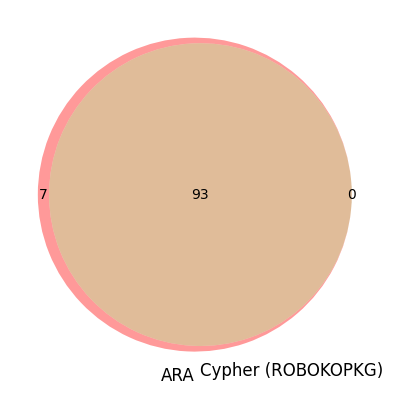

Number of common pathways: 93
Number pathways in ARA alone: 7
Number pathways in Cypher (ROBOKOPKG) alone: 0


C:\Users\dnwilliams\AppData\Local\Temp\ipykernel_4636\2799798396.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge_input_common['set_difference'] = df_merge_input_common[label2] - df_merge_input_common[label1]
C:\Users\dnwilliams\AppData\Local\Temp\ipykernel_4636\2799798396.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge_input_diff['set_difference'] = df_merge_input_diff[label2] - df_merge_input_diff[label1]


,ARA,Cypher (ROBOKOPKG)
NCBIGene:133522|NCBIGene:6927|MONDO:0018840,2.0,0.0
NCBIGene:10891|NCBIGene:6927|MONDO:0018840,2.0,0.0
NCBIGene:133522|NCBIGene:5972|MONDO:0018840,2.0,0.0
NCBIGene:10891|NCBIGene:5972|MONDO:0018840,2.0,0.0
NCBIGene:5465|NCBIGene:9104|HP:0001395,2.0,0.0
NCBIGene:133522|NCBIGene:5972|HP:0001395,1.0,0.0
NCBIGene:10891|NCBIGene:5972|HP:0001395,1.0,0.0


,ARA,Cypher (ROBOKOPKG)


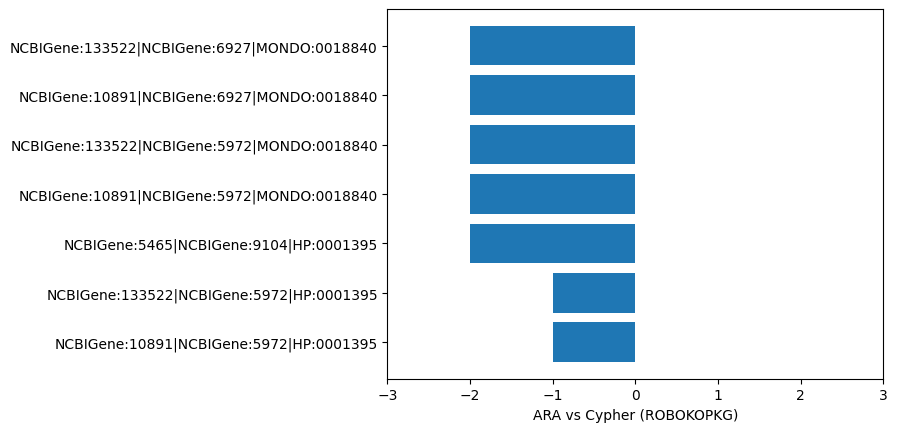

In [30]:
# ARA and Cypher (robokopkg) sets
output_file_name = os.path.join(write_dir_compare,"compare_ara_vs_cypher-robokopkg.txt")
compare_results(results_df_ARA,results_df_Cypher_ROBOKOPKG, output_file_name, "ARA", "Cypher (ROBOKOPKG)")

Node pathways in common:



,n00,n01,n02
0,PPARA,CCN2,Hepatic fibrosis
1,PPARA,VEGFA,Hepatic fibrosis
2,PPARGC1A,MMP2,Hepatic fibrosis
3,peroxisome proliferator-activated receptor alpha isoform 1 (human),CYP2R1,Hepatic fibrosis
4,PPARA,PKHD1,isolated congenital hepatic fibrosis
...,...,...,...
95,peroxisome proliferator-activated receptor alpha isoform 1 (human),CP,Hepatic fibrosis
96,PPARA,IL6,Hepatic fibrosis
97,PPARGC1B,STAT1,Hepatic fibrosis
98,PPARA,THBS1,isolated congenital hepatic fibrosis



Node pathways in ARA only:



,n00,n01,n02



Node pathways in Cypher (Automat) only:



,n00,n01,n02


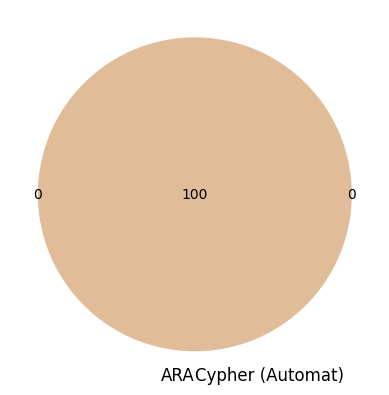

Number of common pathways: 100
Number pathways in ARA alone: 0
Number pathways in Cypher (Automat) alone: 0


,ARA,Cypher (Automat)


,ARA,Cypher (Automat)


ValueError: max() arg is an empty sequence

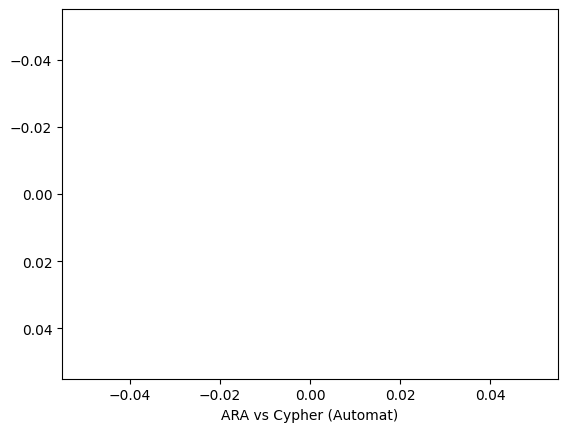

In [25]:
# ARA and Cypher (automat) sets
output_file_name = os.path.join(write_dir_compare,"compare_ara_vs_cypher-automat.txt")
compare_results(results_df_ARA,results_df_Cypher_Automat, output_file_name, "ARA", "Cypher (Automat)")

Node pathways in common:



,n00,n01,n02
0,PPARA,CCN2,Hepatic fibrosis
1,PPARA,VEGFA,Hepatic fibrosis
2,PPARGC1A,MMP2,Hepatic fibrosis
3,peroxisome proliferator-activated receptor alpha isoform 1 (human),CYP2R1,Hepatic fibrosis
4,PPARA,PKHD1,isolated congenital hepatic fibrosis
...,...,...,...
95,peroxisome proliferator-activated receptor alpha isoform 1 (human),CP,Hepatic fibrosis
96,PPARA,IL6,Hepatic fibrosis
97,PPARGC1B,STAT1,Hepatic fibrosis
98,PPARA,THBS1,isolated congenital hepatic fibrosis



Node pathways in ARA only:



,n00,n01,n02



Node pathways in TRAPI only:



,n00,n01,n02


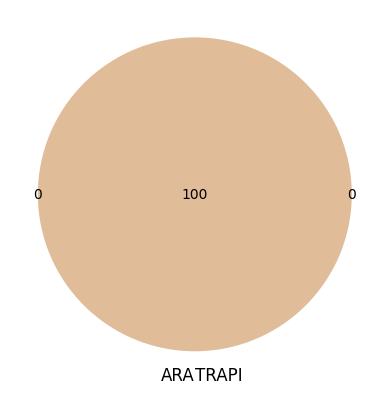

Number of common pathways: 100
Number pathways in ARA alone: 0
Number pathways in TRAPI alone: 0


,ARA,TRAPI


,ARA,TRAPI


ValueError: max() arg is an empty sequence

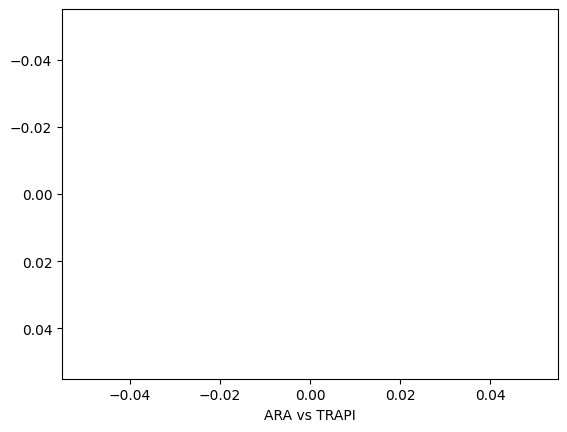

In [26]:
# ARA and TRAPI
output_file_name = os.path.join(write_dir_compare,"compare_ara_vs_trapi.txt")
compare_results(results_df_ARA,results_df_TRAPI, output_file_name, "ARA", "TRAPI")

Node pathways in common:



,n00,n01,n02
0,NCBIGene:133522,NCBIGene:213,HP:0001395
1,NCBIGene:133522,NCBIGene:6347,HP:0001395
2,UniProtKB:Q9UBK2-1,NCBIGene:183,HP:0001395
3,NCBIGene:10891,NCBIGene:2200,HP:0001395
4,NCBIGene:80205,NCBIGene:183,MONDO:0018840
...,...,...,...
88,NCBIGene:5465,NCBIGene:4313,HP:0001395
89,UniProtKB:Q07869-1,NCBIGene:3875,HP:0001395
90,NCBIGene:5465,MONDO:0005154,MONDO:0018840
91,NCBIGene:133522,NCBIGene:405,HP:0001395



Node pathways in Cypher (Automat) only:



,n00,n01,n02
0,NCBIGene:133522,NCBIGene:5972,HP:0001395
1,NCBIGene:133522,NCBIGene:6927,MONDO:0018840
2,NCBIGene:5465,NCBIGene:9104,HP:0001395
3,NCBIGene:10891,NCBIGene:5972,HP:0001395
4,NCBIGene:133522,NCBIGene:5972,MONDO:0018840
5,NCBIGene:10891,NCBIGene:5972,MONDO:0018840
6,NCBIGene:10891,NCBIGene:6927,MONDO:0018840



Node pathways in Cypher (ROBOKOPKG) only:



,n00,n01,n02


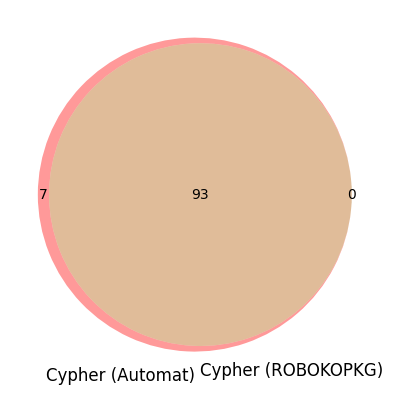

Number of common pathways: 93
Number pathways in Cypher (Automat) alone: 7
Number pathways in Cypher (ROBOKOPKG) alone: 0


C:\Users\dnwilliams\AppData\Local\Temp\ipykernel_4636\2799798396.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge_input_common['set_difference'] = df_merge_input_common[label2] - df_merge_input_common[label1]
C:\Users\dnwilliams\AppData\Local\Temp\ipykernel_4636\2799798396.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge_input_diff['set_difference'] = df_merge_input_diff[label2] - df_merge_input_diff[label1]


,Cypher (Automat),Cypher (ROBOKOPKG)
NCBIGene:5465|NCBIGene:9104|HP:0001395,1.0,0.0
NCBIGene:133522|NCBIGene:6927|MONDO:0018840,1.0,0.0
NCBIGene:10891|NCBIGene:5972|HP:0001395,1.0,0.0
NCBIGene:10891|NCBIGene:5972|MONDO:0018840,1.0,0.0
NCBIGene:10891|NCBIGene:6927|MONDO:0018840,1.0,0.0
NCBIGene:133522|NCBIGene:5972|MONDO:0018840,1.0,0.0
NCBIGene:133522|NCBIGene:5972|HP:0001395,1.0,0.0


,Cypher (Automat),Cypher (ROBOKOPKG)


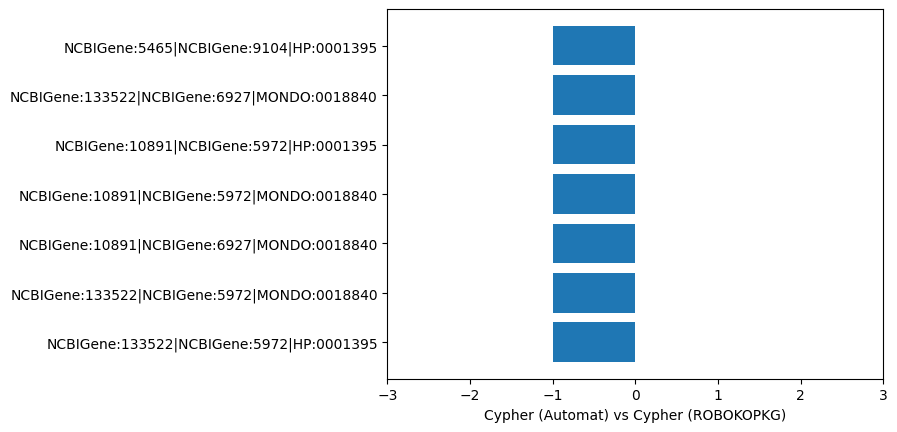

In [32]:
# Cypher (automat) and Cypher (robokopkg) sets
output_file_name = os.path.join(write_dir_compare,"compare_cypher-automat_vs_cypher-robokopkg.txt")
compare_results(results_df_Cypher_Automat,results_df_Cypher_ROBOKOPKG, output_file_name, "Cypher (Automat)", "Cypher (ROBOKOPKG)")

In [ ]:
# ExEmPLAR and Cypher (robokopkg) sets
results_df_exemplar_names = results_df_exemplar[[c for c in results_df_exemplar.columns if "_name" in c]]
output_file_name = os.path.join(write_dir_compare,"compare_exemplar_vs_cypher-robokopkg.txt")
compare_results(results_df_exemplar_names,results_df_Cypher_ROBOKOPKG, output_file_name, "ExEmPLAR", "Cypher (ROBOKOPKG)")

In [ ]:
# ExEmPLAR and Cypher (automat) sets
results_df_exemplar_names = results_df_exemplar[[c for c in results_df_exemplar.columns if "_name" in c]]
output_file_name = os.path.join(write_dir_compare,"compare_exemplar_vs_cypher-automat.txt")
compare_results(results_df_exemplar_names,results_df_Cypher_Automat, output_file_name, "ExEmPLAR", "Cypher (Automat)")

In [ ]:
# ARA and Question Builder (Biological Entity) sets
output_file_name = os.path.join(write_dir_compare,"compare_ARA_vs_qbuilder_bio_entity.txt")
compare_results(results_df_ARA,results_df_qbuilder_bio_entity, output_file_name, "ARA", "Question-Builder (Biological Entity)")

In [ ]:
# ARA (PPARA-Hepatic Fibrosis) and Question Builder (Biological Entity) sets
output_file_name = os.path.join(write_dir_compare,"compare_ARA_PPARA_Fibrosis_vs_qbuilder_bio_entity.txt")
compare_results(results_df_ARA_PPARA_Fibrosis,results_df_qbuilder_bio_entity, output_file_name, "ARA (PPARA-Hepatic Fibrosis)", "Question-Builder (Biological Entity)")

In [ ]:
# ARA and Question Builder (Blank intermediate) sets
output_file_name = os.path.join(write_dir_compare,"compare_ARA_vs_qbuilder_blank.txt")
compare_results(results_df_ARA,results_df_qbuilder_blank, output_file_name, "ARA", "Question-Builder (Blank intermediate)")

In [ ]:
# Cypher ROBOKOPKG comparison (for loop vs single line)
output_file_name = os.path.join(write_dir_compare,"compare_robokopkg_cypher_single_vs_for_loop.txt")
compare_results(results_df_Cypher_ROBOKOPKG,results_df_Cypher_ROBOKOPKG_single, output_file_name, "For Loop", "Single query")